# RAG Evaluation - Test Set Generation with Hybrid Coverage

**Approach:** Hybrid (Spatial + Chunk-Based Coverage)

**Pipeline:**
1. Spatial division (4 regions)
2. Recursive chunking with overlap
3. RAGAS generation (40 raw questions per doc)
4. Custom refinement (domain, difficulty, type)
5. Quality filtering
6. Final selection (20 questions per doc)

**Goal:** Generate high-quality test sets with guaranteed coverage

## 1. Setup & Imports

In [ ]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Any, Tuple
from dataclasses import dataclass
from tqdm.notebook import tqdm

# LangChain
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, UnstructuredWordDocumentLoader
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document

# RAGAS
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from datasets import Dataset

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# os
from dotenv import load_dotenv
load_dotenv()

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ All imports successful")

✅ All imports successful


In [3]:
os.chdir("C:/Users/sa007769/Downloads/Rag_Eval")

## 2. Configuration

In [4]:
@dataclass
class MVPConfig:
    """Simple MVP Configuration"""
    
    # Azure OpenAI Settings
    azure_endpoint: str = "https://your-endpoint.openai.azure.com/"
    azure_api_key: str = "your-api-key"
    azure_api_version: str = "2024-02-01"
    azure_deployment_gpt4: str = "gpt-4"
    azure_deployment_embedding: str = "text-embedding-ada-002"


    # Embedding
    azure_emb_endpoint: str = "https://your-endpoint.openai.azure.com/"
    azure_emb_api_key: str = "your-api-key"
    azure_emb_deployment: str = "text-embedding-ada-002"
    azure_emb_version: str = "2024-02-01"
    
    
    # Coverage Strategy
    num_spatial_regions: int = 4  # Divide into 4 quarters
    questions_per_document: int = 20  # Fixed
    questions_per_region: int = 5  # Equal distribution (20 ÷ 4)
    
    # Chunking (Recursive)
    chunk_size: int = 1000  # tokens
    chunk_overlap: int = 200  # tokens (20% overlap)
    separators: List[str] = None  # Will use default
    
    # RAGAS Generation
    ragas_overgeneration_factor: float = 2.0  # Generate 2x for filtering
    ragas_test_size_per_doc: int = 40  # 40 raw questions per doc
    
    # Question Distribution (for RAGAS)
    simple_questions_pct: float = 0.3  # 30%
    reasoning_questions_pct: float = 0.4  # 40%
    multi_context_questions_pct: float = 0.3  # 30%
    
    # Quality Filtering
    min_quality_score: float = 7.0  # Out of 10
    min_specificity_score: float = 6.0
    min_domain_relevance: float = 7.0
    
    # Difficulty Distribution (Final)
    difficulty_easy_pct: float = 0.10  # 10% easy (2 questions)
    difficulty_medium_pct: float = 0.30  # 30% medium (6 questions)
    difficulty_hard_pct: float = 0.60  # 60% hard (12 questions)
    
    # Domain Specifics (BIS/Banking)
    domain_name: str = "Banking and Financial Services (BIS)"
    domain_terminology: List[str] = None
    
    # LLM Parameters
    temperature_generation: float = 0.7
    temperature_validation: float = 0.1
    max_tokens: int = 2000
    
    def __post_init__(self):
        if self.separators is None:
            self.separators = ["\n\n", "\n", ". ", " ", ""]
        
        if self.domain_terminology is None:
            self.domain_terminology = [
                "compliance", "Basel III", "regulatory reporting",
                "audit trail", "escalation matrix", "MiFID II",
                "Enhanced Due Diligence", "cross-border",
                "operational risk", "internal controls",
                "KYC", "AML", "regulatory framework"
            ]

# Create configuration
config = MVPConfig()

print("✅ Configuration created")
print(f"   Spatial regions: {config.num_spatial_regions}")
print(f"   Questions per document: {config.questions_per_document}")
print(f"   Questions per region: {config.questions_per_region}")
print(f"   Chunk size: {config.chunk_size} tokens")
print(f"   Chunk overlap: {config.chunk_overlap} tokens")

✅ Configuration created
   Spatial regions: 4
   Questions per document: 20
   Questions per region: 5
   Chunk size: 1000 tokens
   Chunk overlap: 200 tokens


In [5]:
# Update with your Azure credentials
config.azure_endpoint = os.getenv("AZURE_OAI_ENDPOINT")
config.azure_api_key = os.getenv("AZURE_OAI_API_KEY")
config.azure_deployment_gpt4 = os.getenv("AZURE_OAI_DEPLOYMENT")
config.azure_api_version = os.getenv("AZURE_OAI_API_VERSION")

# Update with your Azure credentials
config.azure_emb_endpoint = os.getenv("AZURE_OAI_EMB_ENDPOINT")
config.azure_emb_api_key = os.getenv("AZURE_OAI_EMB_API_KEY")
config.azure_emb_deployment = os.getenv("AZURE_OAI_EMB_DEPLOYMENT")
config.azure_emb_version = os.getenv("AZURE_OAI_EMB_API_VERSION")

print("✅ Credentials configured")

✅ Credentials configured


## 3. Initialize LLM and Embeddings

In [6]:
# Initialize Azure ChatOpenAI
llm_generator = AzureChatOpenAI(
    azure_endpoint=config.azure_endpoint,
    api_key=config.azure_api_key,
    api_version=config.azure_api_version,
    deployment_name=config.azure_deployment_gpt4,
    temperature=config.temperature_generation,
    max_tokens=config.max_tokens,
)

# LLM for validation (lower temperature)
llm_validator = AzureChatOpenAI(
    azure_endpoint=config.azure_endpoint,
    api_key=config.azure_api_key,
    api_version=config.azure_api_version,
    deployment_name=config.azure_deployment_gpt4,
    temperature=config.temperature_validation,
    max_tokens=config.max_tokens,
)

# Initialize Azure OpenAI Embeddings
embeddings = AzureOpenAIEmbeddings(
    model=os.getenv("AZURE_OAI_EMB_DEPLOYMENT"),
    azure_endpoint=os.getenv("AZURE_OAI_EMB_ENDPOINT"),
    api_key=os.getenv("AZURE_OAI_EMB_API_KEY"),
    openai_api_version=os.getenv("AZURE_OAI_EMB_API_VERSION")
)


# Test LLM
test_response = llm_generator.invoke("Say 'LLM generator working'")
print(f"✅ LLM Test: {test_response.content}")


# Test LLM
test_response = llm_validator.invoke("Say 'LLM validator working'")
print(f"✅ LLM Test: {test_response.content}")

# Test Embeddings
test_embedding = embeddings.embed_query("test")
print(f"✅ Embeddings Test: Generated {len(test_embedding)} dimensions")

✅ LLM Test: LLM generator working
✅ LLM Test: LLM validator working
✅ Embeddings Test: Generated 3072 dimensions


## 4. Document Loading

In [7]:
# Specify your documents directory
DOCUMENTS_DIR = "./documents"  # Change this to your directory

# Create directory if it doesn't exist
Path(DOCUMENTS_DIR).mkdir(parents=True, exist_ok=True)

print(f"Documents directory: {DOCUMENTS_DIR}")
print(f"Put your PDF/DOCX files in this directory")

Documents directory: ./documents
Put your PDF/DOCX files in this directory


In [8]:
#%pip install pypdf

In [9]:
from tqdm import tqdm  # Use standard tqdm

def load_documents(documents_dir: str) -> List[Document]:
    documents = []
    doc_dir = Path(documents_dir)
    
    # Load PDFs
    pdf_files = list(doc_dir.glob("*.pdf"))
    for pdf_file in tqdm(pdf_files, desc="Loading PDFs"):
        try:
            loader = PyPDFLoader(str(pdf_file))
            docs = loader.load()
            for doc in docs:
                doc.metadata["source_file"] = pdf_file.name
                doc.metadata["file_type"] = "pdf"
            documents.extend(docs)
        except Exception as e:
            print(f"Error loading {pdf_file.name}: {e}")
    
    return documents

# Load documents
documents = load_documents(DOCUMENTS_DIR)

print(f"\n✅ Total documents loaded: {len(documents)}")

if len(documents) == 0:
    print("⚠️  No documents found!")
    print(f"   Please add PDF or DOCX files to: {DOCUMENTS_DIR}")
else:
    # Group by source file
    files = {}
    for doc in documents:
        source = doc.metadata.get("source_file", "unknown")
        files[source] = files.get(source, 0) + 1
    
    print("\nDocuments by file:")
    for file, count in files.items():
        print(f"  - {file}: {count} pages/sections")

Loading PDFs: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


✅ Total documents loaded: 26

Documents by file:
  - othp33.pdf: 26 pages/sections


## 5. Spatial Coverage + Recursive Chunking

In [10]:
class SpatialChunkCoverage:
    """
    Hybrid Coverage: Spatial regions + Recursive chunking
    """
    
    def __init__(self, config: MVPConfig):
        self.config = config
        
        # Initialize recursive text splitter
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=config.chunk_size,
            chunk_overlap=config.chunk_overlap,
            separators=config.separators,
            length_function=len,  # Character count
        )
    
    def chunk_documents(self, documents: List[Document]) -> Dict[str, List[Document]]:
        """
        Group documents by source file and chunk each.
        
        Returns:
            Dict[source_file -> List[chunks]]
        """
        # Group by source file
        docs_by_file = {}
        for doc in documents:
            source = doc.metadata.get("source_file", "unknown")
            if source not in docs_by_file:
                docs_by_file[source] = []
            docs_by_file[source].append(doc)
        
        # Chunk each file
        chunked_docs = {}
        for source, docs in docs_by_file.items():
            # Combine all pages/sections into one text
            combined_text = "\n\n".join([d.page_content for d in docs])
            
            # Create a single document
            combined_doc = Document(
                page_content=combined_text,
                metadata={"source_file": source}
            )
            
            # Chunk
            chunks = self.text_splitter.split_documents([combined_doc])
            
            # Add chunk index
            for i, chunk in enumerate(chunks):
                chunk.metadata["chunk_index"] = i
                chunk.metadata["total_chunks"] = len(chunks)
            
            chunked_docs[source] = chunks
            print(f"  ✓ {source}: {len(chunks)} chunks")
        
        return chunked_docs
    
    def divide_into_spatial_regions(self, chunks: List[Document]) -> Dict[int, List[Document]]:
        """
        Divide chunks into N spatial regions (quarters).
        
        Returns:
            Dict[region_id -> List[chunks]]
        """
        total_chunks = len(chunks)
        chunks_per_region = total_chunks / self.config.num_spatial_regions
        
        regions = {}
        for i in range(self.config.num_spatial_regions):
            start_idx = int(i * chunks_per_region)
            end_idx = int((i + 1) * chunks_per_region) if i < self.config.num_spatial_regions - 1 else total_chunks
            
            region_chunks = chunks[start_idx:end_idx]
            
            # Add region metadata
            for chunk in region_chunks:
                chunk.metadata["region_id"] = i
                chunk.metadata["region_name"] = f"Region {i+1}"
            
            regions[i] = region_chunks
        
        return regions
    
    def sample_chunks_from_regions(self, regions: Dict[int, List[Document]]) -> List[Document]:
        """
        Sample N chunks from each region uniformly.
        
        For MVP: Sample equal number from each region (questions_per_region)
        """
        sampled_chunks = []
        
        for region_id, region_chunks in regions.items():
            n_samples = self.config.questions_per_region
            n_available = len(region_chunks)
            
            if n_available == 0:
                print(f"  ⚠️  Region {region_id+1}: No chunks available")
                continue
            
            # Calculate sampling step
            if n_available <= n_samples:
                # Sample all
                selected = region_chunks
            else:
                # Uniform sampling (every Nth chunk)
                step = n_available / n_samples
                indices = [int(i * step) for i in range(n_samples)]
                selected = [region_chunks[i] for i in indices]
            
            # Mark as sampled
            for chunk in selected:
                chunk.metadata["sampled"] = True
            
            sampled_chunks.extend(selected)
            print(f"  ✓ Region {region_id+1}: Sampled {len(selected)}/{n_available} chunks")
        
        return sampled_chunks

# Initialize coverage strategy
coverage_strategy = SpatialChunkCoverage(config)

print("✅ Coverage strategy initialized")

✅ Coverage strategy initialized


In [11]:
# Chunk all documents
print("Chunking documents...")
chunked_docs_by_file = coverage_strategy.chunk_documents(documents)

print(f"\n✅ Chunked {len(chunked_docs_by_file)} files")

# Show statistics
total_chunks = sum(len(chunks) for chunks in chunked_docs_by_file.values())
print(f"   Total chunks: {total_chunks}")
print(f"   Average chunks per file: {total_chunks / len(chunked_docs_by_file):.1f}")

Chunking documents...
  ✓ othp33.pdf: 101 chunks

✅ Chunked 1 files
   Total chunks: 101
   Average chunks per file: 101.0


In [12]:
# For each file: divide into regions and sample
sampled_chunks_by_file = {}

for source_file, chunks in chunked_docs_by_file.items():
    print(f"\nProcessing: {source_file}")
    print(f"  Total chunks: {len(chunks)}")
    
    # Divide into spatial regions
    regions = coverage_strategy.divide_into_spatial_regions(chunks)
    
    print(f"  Divided into {len(regions)} regions:")
    for region_id, region_chunks in regions.items():
        print(f"    Region {region_id+1}: {len(region_chunks)} chunks")
    
    # Sample from each region
    print(f"  Sampling {config.questions_per_region} chunks per region...")
    sampled = coverage_strategy.sample_chunks_from_regions(regions)
    
    sampled_chunks_by_file[source_file] = sampled
    print(f"  ✓ Total sampled: {len(sampled)} chunks")

print(f"\n✅ Sampling complete for all files")
total_sampled = sum(len(chunks) for chunks in sampled_chunks_by_file.values())
print(f"   Total sampled chunks: {total_sampled}")


Processing: othp33.pdf
  Total chunks: 101
  Divided into 4 regions:
    Region 1: 25 chunks
    Region 2: 25 chunks
    Region 3: 25 chunks
    Region 4: 26 chunks
  Sampling 5 chunks per region...
  ✓ Region 1: Sampled 5/25 chunks
  ✓ Region 2: Sampled 5/25 chunks
  ✓ Region 3: Sampled 5/25 chunks
  ✓ Region 4: Sampled 5/26 chunks
  ✓ Total sampled: 20 chunks

✅ Sampling complete for all files
   Total sampled chunks: 20


## 6. RAGAS Test Generation

In [13]:
# Initialize RAGAS TestsetGenerator
generator = TestsetGenerator.from_langchain(
    generator_llm=llm_generator,
    critic_llm=llm_validator,
    embeddings=embeddings,
)

print("✅ RAGAS generator initialized")

✅ RAGAS generator initialized


In [14]:
# Generate test set from sampled chunks
all_raw_questions = []

for source_file, sampled_chunks in sampled_chunks_by_file.items():
    print(f"\nGenerating questions for: {source_file}")
    print(f"  Sampled chunks: {len(sampled_chunks)}")
    
    # Calculate test size (2 questions per chunk for overgeneration)
    test_size = len(sampled_chunks) * 2
    
    print(f"  Generating {test_size} questions...")
    
    try:
        # Generate with RAGAS
        testset = generator.generate_with_langchain_docs(
            sampled_chunks,
            test_size=test_size,
            distributions={
                simple: config.simple_questions_pct,
                reasoning: config.reasoning_questions_pct,
                multi_context: config.multi_context_questions_pct,
            },
        )
        
        # Convert to pandas
        df = testset.to_pandas()
        df["source_file"] = source_file
        
        all_raw_questions.append(df)
        
        print(f"  ✓ Generated {len(df)} questions")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")
        continue

# Combine all
if all_raw_questions:
    raw_questions_df = pd.concat(all_raw_questions, ignore_index=True)
    print(f"\n✅ Total raw questions generated: {len(raw_questions_df)}")
else:
    print("\n❌ No questions generated")
    raw_questions_df = pd.DataFrame()


Generating questions for: othp33.pdf
  Sampled chunks: 20
  Generating 40 questions...


Filename and doc_id are the same for all nodes.                 
Generating: 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


  ✓ Generated 40 questions

✅ Total raw questions generated: 40


In [15]:
# View sample questions
if len(raw_questions_df) > 0:
    print("Sample generated questions:\n")
    for i, row in raw_questions_df.head(3).iterrows():
        print(f"{i+1}. Question: {row['question']}")
        print(f"   Ground Truth: {row['ground_truth']}")
        print(f"   Source: {row['source_file']}")
        print()

Sample generated questions:

1. Question: How could significant foreign holdings of a CBDC lead to stronger international spillovers?
   Ground Truth: Significant foreign holdings of a CBDC could result in stronger unintended international spillovers, specifically undesirable volatility in foreign exchange rates and 'digital dollarisation' for other countries.
   Source: othp33.pdf

2. Question: What are the core features required for central bank digital currencies (CBDC) to fulfill their foundational principles?
   Ground Truth: The core features required for central bank digital currencies (CBDC) to fulfill their foundational principles include: 1) Convertible: a CBDC should exchange at par with cash and private money to maintain singleness of the currency; 2) Convenient: CBDC payments should be as easy as using cash, tapping with a card, or scanning a mobile phone to encourage adoption and accessibility; 3) Accepted and available: a CBDC should be usable in many of the same types o

## 7. Custom Prompts for Refinement

**This is where you control:**
- Question type
- Difficulty level
- Domain terminology
- Answer format
- Reasoning requirements

In [16]:
# Domain Refinement Prompt
DOMAIN_REFINEMENT_PROMPT = PromptTemplate(
    input_variables=["question", "ground_truth", "context"],
    template="""
You are refining a test question for {domain_name} documentation.

ORIGINAL QUESTION:
{question}

ORIGINAL ANSWER:
{ground_truth}

DOCUMENT CONTEXT:
{context}

DOMAIN REQUIREMENTS:
- Use specific terminology: {domain_terms}
- Reference concrete frameworks, policies, or procedures
- Include realistic operational scenarios
- Be specific about sections, tables, or document references
- Avoid generic phrasing

EXAMPLES OF GOOD REFINEMENT:

Before: "What should be done when there's a problem?"
After: "According to the Operational Risk Framework Section 4.2, what is the escalation procedure when a regulatory compliance issue is identified outside standard business hours?"

Before: "How does this process work?"
After: "What are the sequential approval steps required for cross-border meeting arrangements under the Enhanced Due Diligence protocol?"

TASK:
Refine the question and answer to be more domain-specific and professional.

OUTPUT (JSON format):
{{
    "refined_question": "...",
    "refined_answer": "...",
    "domain_terms_added": ["term1", "term2"]
}}
"""
)

# Difficulty Calibration Prompt  
DIFFICULTY_CALIBRATION_PROMPT = PromptTemplate(
    input_variables=["question", "target_difficulty"],
    template="""
You are calibrating the difficulty of a test question.

QUESTION:
{question}

TARGET DIFFICULTY: {target_difficulty}

DIFFICULTY LEVELS:
- easy: Direct fact retrieval from single sentence/table cell
- medium: Requires understanding 2-3 related pieces of information
- hard: Multi-hop reasoning, synthesis, or complex analysis

ADJUSTMENT RULES:

To INCREASE difficulty (make harder):
- Add temporal constraints ("during Q3...")
- Require synthesis of multiple sections
- Include edge cases ("what if both conditions apply...")
- Add comparison elements ("how does X differ from Y when...")
- Require reasoning about exceptions or special cases

To DECREASE difficulty (make easier):
- Make more specific and direct
- Focus on single fact or concept
- Remove ambiguity
- Ask for straightforward information

TASK:
Adjust the question to match the target difficulty: {target_difficulty}

OUTPUT (JSON format):
{{
    "adjusted_question": "...",
    "difficulty_level": "easy|medium|hard",
    "reasoning_hops": 1-5
}}
"""
)

# Quality Validation Prompt
QUALITY_VALIDATION_PROMPT = PromptTemplate(
    input_variables=["question", "ground_truth"],
    template="""
You are a quality validator for test questions.

QUESTION:
{question}

GROUND TRUTH ANSWER:
{ground_truth}

EVALUATE ON THESE CRITERIA (1-10 scale):

1. SPECIFICITY: Is the question specific and unambiguous?
   Score 1: Extremely vague ("What is mentioned?")
   Score 10: Highly specific ("According to Table 3, Section 4.2...")

2. DOMAIN RELEVANCE: Does it use appropriate domain terminology?
   Score 1: Generic, could apply anywhere
   Score 10: Clearly domain-specific with technical terms

3. ANSWER CLARITY: Is the answer clear and complete?
   Score 1: Ambiguous or incomplete
   Score 10: Crystal clear and comprehensive

4. REASONING REQUIREMENT: Does it require thinking beyond recall?
   Score 1: Pure memorization
   Score 10: Deep analysis or synthesis required

OVERALL QUALITY: Average of all scores
PASS THRESHOLD: >= 7.0

OUTPUT (JSON format):
{{
    "specificity": 1-10,
    "domain_relevance": 1-10,
    "answer_clarity": 1-10,
    "reasoning_requirement": 1-10,
    "overall_quality": 1-10,
    "pass": true/false,
    "feedback": "Brief explanation"
}}
"""
)

print("✅ Custom prompts defined")
print("\nYou can modify these prompts to control:")
print("  - Question type and style")
print("  - Difficulty level")
print("  - Domain specificity")
print("  - Answer format")
print("  - Quality criteria")

✅ Custom prompts defined

You can modify these prompts to control:
  - Question type and style
  - Difficulty level
  - Domain specificity
  - Answer format
  - Quality criteria


## 8. Refinement & Quality Filtering

**Apply custom prompts to refine questions**

In [17]:
def refine_question_domain(question: str, ground_truth: str, context: str) -> Dict:
    """
    Apply domain refinement using custom prompt.
    """
    prompt = DOMAIN_REFINEMENT_PROMPT.format(
        domain_name=config.domain_name,
        question=question,
        ground_truth=ground_truth,
        context=context[:1000],  # Limit context length
        domain_terms=", ".join(config.domain_terminology[:10])
    )
    
    try:
        response = llm_generator.invoke(prompt)
        result = json.loads(response.content)
        return result
    except Exception as e:
        print(f"Error in domain refinement: {e}")
        return {
            "refined_question": question,
            "refined_answer": ground_truth,
            "domain_terms_added": []
        }

def validate_quality(question: str, ground_truth: str) -> Dict:
    """
    Validate question quality using custom prompt.
    """
    prompt = QUALITY_VALIDATION_PROMPT.format(
        question=question,
        ground_truth=ground_truth
    )
    
    try:
        response = llm_validator.invoke(prompt)
        result = json.loads(response.content)
        return result
    except Exception as e:
        print(f"Error in quality validation: {e}")
        return {
            "overall_quality": 5.0,
            "pass": False,
            "feedback": f"Validation error: {e}"
        }

print("✅ Refinement functions defined")

✅ Refinement functions defined


In [18]:
# Apply refinement and filtering
# NOTE: This will make LLM API calls - can be slow and costly!
# For MVP: Process a subset first to test

PROCESS_ALL = False  # Set to True to process all questions
TEST_SAMPLE_SIZE = 10  # For testing, process only 10 questions

if not PROCESS_ALL:
    print(f"⚠️  TEST MODE: Processing only {TEST_SAMPLE_SIZE} questions")
    print("   Set PROCESS_ALL = True to process all questions\n")
    questions_to_process = raw_questions_df.head(TEST_SAMPLE_SIZE)
else:
    questions_to_process = raw_questions_df

refined_questions = []

for idx, row in tqdm(questions_to_process.iterrows(), total=len(questions_to_process), desc="Refining"):
    # Get context (combine if available)
    context = row.get('contexts', [''])[0] if isinstance(row.get('contexts'), list) else ''
    
    # Step 1: Domain refinement
    refined = refine_question_domain(
        question=row['question'],
        ground_truth=row['ground_truth'],
        context=context
    )
    
    # Step 2: Quality validation
    validation = validate_quality(
        question=refined['refined_question'],
        ground_truth=refined['refined_answer']
    )
    
    # Combine results
    refined_row = {
        'source_file': row['source_file'],
        'original_question': row['question'],
        'original_answer': row['ground_truth'],
        'refined_question': refined['refined_question'],
        'refined_answer': refined['refined_answer'],
        'domain_terms': refined.get('domain_terms_added', []),
        'quality_score': validation.get('overall_quality', 0),
        'specificity': validation.get('specificity', 0),
        'domain_relevance': validation.get('domain_relevance', 0),
        'answer_clarity': validation.get('answer_clarity', 0),
        'reasoning_requirement': validation.get('reasoning_requirement', 0),
        'passed_quality': validation.get('pass', False),
        'feedback': validation.get('feedback', ''),
    }
    
    refined_questions.append(refined_row)

# Create DataFrame
refined_df = pd.DataFrame(refined_questions)

print(f"\n✅ Refinement complete")
print(f"   Processed: {len(refined_df)} questions")
print(f"   Passed quality filter: {refined_df['passed_quality'].sum()}")
print(f"   Average quality score: {refined_df['quality_score'].mean():.2f}/10")

⚠️  TEST MODE: Processing only 10 questions
   Set PROCESS_ALL = True to process all questions



Refining: 100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


✅ Refinement complete
   Processed: 10 questions
   Passed quality filter: 10
   Average quality score: 9.00/10


In [19]:
# Filter by quality
quality_filtered_df = refined_df[refined_df['passed_quality'] == True].copy()

print(f"Quality Filtering Results:")
print(f"  Original: {len(refined_df)}")
print(f"  Passed: {len(quality_filtered_df)}")
print(f"  Filtered out: {len(refined_df) - len(quality_filtered_df)}")
print(f"  Pass rate: {len(quality_filtered_df)/len(refined_df)*100:.1f}%")

Quality Filtering Results:
  Original: 10
  Passed: 10
  Filtered out: 0
  Pass rate: 100.0%


In [21]:
# View refined questions
print("\nSample Refined Questions:\n")
for i, row in quality_filtered_df.head(8).iterrows():
    print(f"{i+1}. ORIGINAL: {row['original_question']}")
    print(f"   REFINED:  {row['refined_question']}")
    print(f"   Quality:  {row['quality_score']:.1f}/10")
    print(f"   Domain terms: {', '.join(row['domain_terms'])}")
    print()


Sample Refined Questions:

1. ORIGINAL: How could significant foreign holdings of a CBDC lead to stronger international spillovers?
   REFINED:  According to BIS documentation (see Table 3.1: Cross-Border CBDC Operational Risks), how could significant foreign holdings of a CBDC increase operational risk and trigger compliance challenges, such as unintended international spillovers, under Basel III liquidity requirements and internal controls for cross-border payments?
   Quality:  9.0/10
   Domain terms: Basel III, internal controls, cross-border payments, operational risk, regulatory reporting, audit trails, MiFID II, compliance

2. ORIGINAL: What are the core features required for central bank digital currencies (CBDC) to fulfill their foundational principles?
   REFINED:  Referring to BIS documentation Table 1 (Section 3.2, 'Central bank digital currencies: foundational principles and core features'), what are the instrument-level core features required for CBDCs to maintain compli

## 9. Final Selection & Coverage Verification

In [22]:
# Select final questions (20 per document, 5 per region)
# For MVP: Select top quality questions ensuring regional balance

final_questions = []

for source_file in quality_filtered_df['source_file'].unique():
    file_questions = quality_filtered_df[quality_filtered_df['source_file'] == source_file].copy()
    
    # Sort by quality
    file_questions = file_questions.sort_values('quality_score', ascending=False)
    
    # Select top 20 (or all if less than 20)
    selected = file_questions.head(config.questions_per_document)
    
    final_questions.append(selected)
    
    print(f"{source_file}:")
    print(f"  Available: {len(file_questions)}")
    print(f"  Selected: {len(selected)}")
    print(f"  Avg quality: {selected['quality_score'].mean():.2f}/10")

# Combine
if final_questions:
    final_df = pd.concat(final_questions, ignore_index=True)
    print(f"\n✅ Final test set: {len(final_df)} questions")
else:
    final_df = pd.DataFrame()
    print("\n⚠️  No questions in final set")

othp33.pdf:
  Available: 10
  Selected: 10
  Avg quality: 9.00/10

✅ Final test set: 10 questions


## 10. Coverage Visualization

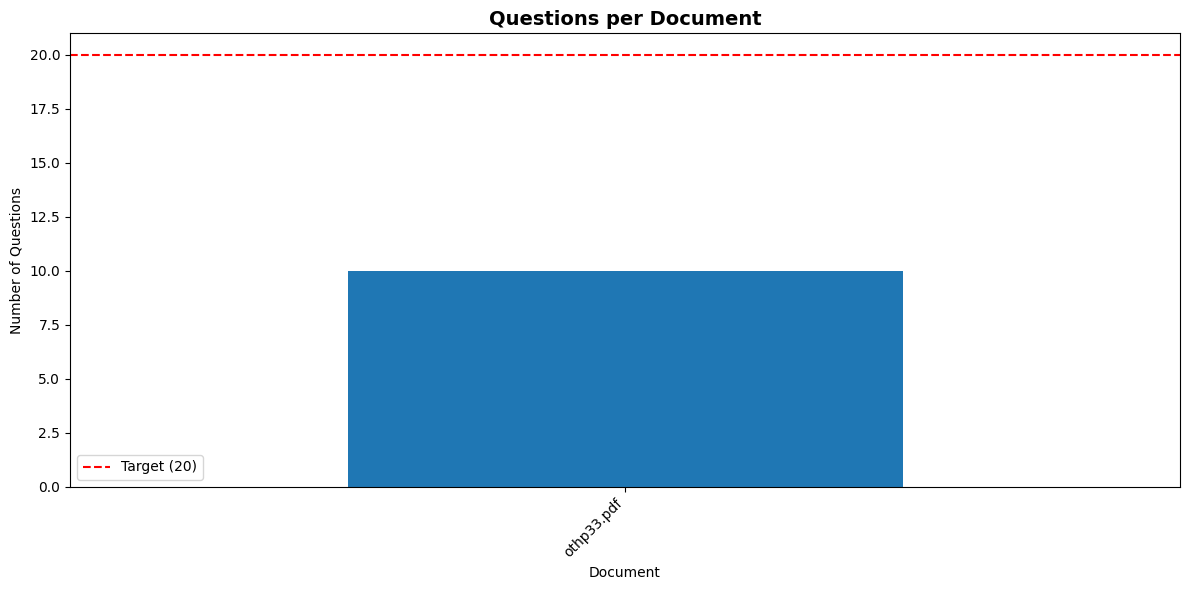


Coverage Statistics:
  Mean: 10.0 questions/doc
  Min: 10 questions/doc
  Max: 10 questions/doc
  Target: 20 questions/doc


In [27]:
# Coverage visualization (simple bar chart)
if len(final_df) > 0:
    coverage_by_file = final_df.groupby('source_file').size()
    
    plt.figure(figsize=(12, 6))
    coverage_by_file.plot(kind='bar')
    plt.title('Questions per Document', fontsize=14, fontweight='bold')
    plt.xlabel('Document')
    plt.ylabel('Number of Questions')
    plt.axhline(y=config.questions_per_document, color='r', linestyle='--', 
                label=f'Target ({config.questions_per_document})')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\nCoverage Statistics:")
    print(f"  Mean: {coverage_by_file.mean():.1f} questions/doc")
    print(f"  Min: {coverage_by_file.min()} questions/doc")
    print(f"  Max: {coverage_by_file.max()} questions/doc")
    print(f"  Target: {config.questions_per_document} questions/doc")
else:
    print("No questions to visualize")

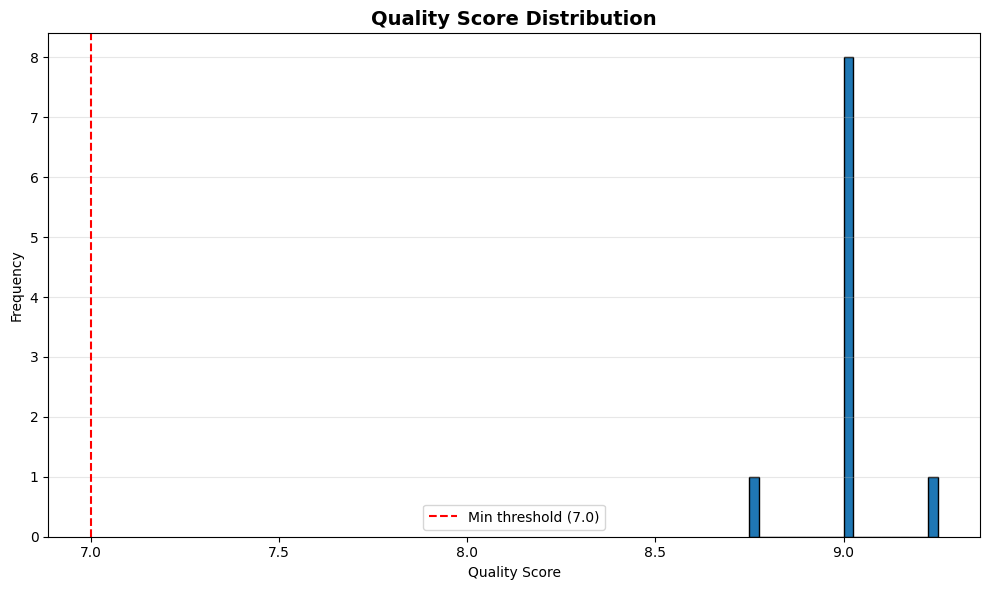


Quality Statistics:
  Mean: 9.00
  Median: 9.00
  Min: 8.75
  Max: 9.25


In [28]:
# Quality score distribution
if len(final_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.hist(final_df['quality_score'], bins=20, edgecolor='black')
    plt.axvline(x=config.min_quality_score, color='r', linestyle='--', 
                label=f'Min threshold ({config.min_quality_score})')
    plt.title('Quality Score Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Quality Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nQuality Statistics:")
    print(f"  Mean: {final_df['quality_score'].mean():.2f}")
    print(f"  Median: {final_df['quality_score'].median():.2f}")
    print(f"  Min: {final_df['quality_score'].min():.2f}")
    print(f"  Max: {final_df['quality_score'].max():.2f}")

## 11. Export Test Set

In [29]:
# Export to CSV
OUTPUT_DIR = "./outputs"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

if len(final_df) > 0:
    # Export final questions
    final_csv = f"{OUTPUT_DIR}/testset_final.csv"
    final_df.to_csv(final_csv, index=False)
    print(f"✅ Exported final test set: {final_csv}")
    
    # Export for RAGAS evaluation format
    ragas_format = final_df[[
        'refined_question', 'refined_answer', 'source_file'
    ]].copy()
    ragas_format.columns = ['question', 'ground_truth', 'source']
    
    ragas_csv = f"{OUTPUT_DIR}/testset_ragas_format.csv"
    ragas_format.to_csv(ragas_csv, index=False)
    print(f"✅ Exported RAGAS format: {ragas_csv}")
    
    # Summary report
    summary = {
        "total_questions": len(final_df),
        "questions_per_document": final_df.groupby('source_file').size().to_dict(),
        "avg_quality_score": float(final_df['quality_score'].mean()),
        "avg_specificity": float(final_df['specificity'].mean()),
        "avg_domain_relevance": float(final_df['domain_relevance'].mean()),
        "avg_reasoning": float(final_df['reasoning_requirement'].mean()),
    }
    
    summary_json = f"{OUTPUT_DIR}/testset_summary.json"
    with open(summary_json, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"✅ Exported summary: {summary_json}")
    
    print(f"\n📊 Test Set Summary:")
    print(json.dumps(summary, indent=2))
else:
    print("⚠️  No questions to export")

✅ Exported final test set: ./outputs/testset_final.csv
✅ Exported RAGAS format: ./outputs/testset_ragas_format.csv
✅ Exported summary: ./outputs/testset_summary.json

📊 Test Set Summary:
{
  "total_questions": 10,
  "questions_per_document": {
    "othp33.pdf": 10
  },
  "avg_quality_score": 9.0,
  "avg_specificity": 8.9,
  "avg_domain_relevance": 10.0,
  "avg_reasoning": 8.2
}


## 12. Next Steps

You now have:
1. ✅ Test set with guaranteed coverage (spatial + chunk-based)
2. ✅ Domain-refined questions with custom prompts
3. ✅ Quality-filtered questions
4. ✅ Coverage visualization
5. ✅ Exported test sets (CSV + JSON)

**Next:**
- Use the test set to evaluate your RAG system with RAGAS
- Iterate on custom prompts to improve question quality
- Adjust difficulty distribution
- Add more documents
- Integrate with your ETL pipeline

## 13. (Optional) RAGAS Evaluation

Evaluate your RAG system with the generated test set

In [ ]:
# This section shows how to use the test set for evaluation
# You would integrate this with your actual RAG system

print("To evaluate your RAG system:")
print("""}
1. Load the test set: testset_ragas_format.csv
2. For each question:
   - Query your RAG system
   - Get answer and retrieved contexts
3. Create evaluation dataset with:
   - question
   - answer (from your RAG)
   - contexts (retrieved chunks)
   - ground_truth (from test set)
4. Run RAGAS evaluation:
   - faithfulness
   - answer_relevancy
   - context_precision
   - context_recall
""")

print("\nExample code:")
print("""}
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy
from datasets import Dataset

# Your evaluation data
eval_data = {
    "question": [...],
    "answer": [...],  # From your RAG
    "contexts": [...],  # Retrieved by your RAG
    "ground_truth": [...]  # From test set
}

dataset = Dataset.from_dict(eval_data)
result = evaluate(dataset, metrics=[faithfulness, answer_relevancy])
print(result)
""")